In [1]:
import os
import spacy
from spacy import displacy
import cv2
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import import_ipynb
from imagePreProcessor import *
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from collections import Counter
from sklearn.cluster import DBSCAN

2023-07-04 13:38:45.402528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


importing Jupyter notebook from imagePreProcessor.ipynb


In [2]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/DynamicZonalOCR'

In [9]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/Data/TallyImages/')

In [18]:
imagePath = "4.jpeg"
image = cv2.imread(imagePath)
image = preProcessImage(image)

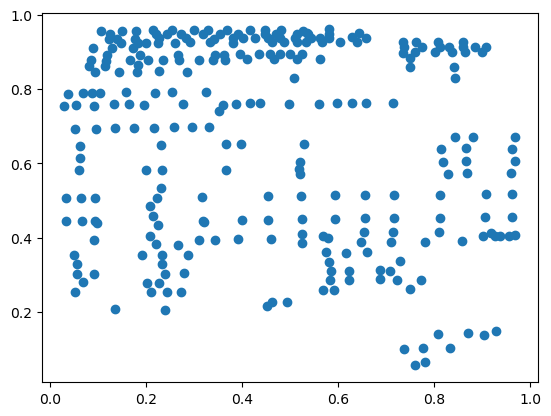

In [19]:
data = pytesseract.image_to_data(image, output_type=Output.DATAFRAME)

data.dropna(inplace=True)
indexesToDrop = []
stopwords = ["", " ", "  ", "/", ":", "-", ".", ",", "\n", "\t", "\\", "(", ")", "[", "]", "{", "}", "*", "&", "%", "$", "#", "|"]
for index in data.index:
    if data["text"][index] in stopwords:
        indexesToDrop.append(index)   
data.drop(indexesToDrop, inplace=True)
data.reset_index(inplace=True)
data.drop(columns=["index"], inplace=True)
for index in data.index:
    data["text"][index] = str(data["text"][index])

data["x"] = data["left"] + data["width"]/2
data["y"] = data["top"] + data["height"]/2

data["x"]/=image.shape[1]
data["y"]/=image.shape[0]

plt.scatter(data["x"], data["y"])
plt.show()

In [20]:
def getUniques(arr):
    unique = []
    for element in arr:
        if element not in unique:
            unique.append(element)
        else:
            pass
    return len(unique)
def estimateParameter(imageName):

    image = cv2.imread(imageName)
    image = preProcessImage(image)

    data = pytesseract.image_to_data(image, output_type=Output.DATAFRAME)

    data.dropna(inplace=True)
    indexesToDrop = []
    stopwords = ["", " ", "  ", "/", ":", "-", ".", ",", "\n", "\t", "\\", "(", ")", "[", "]", "{", "}", "*", "&", "%", "$", "#", "|"]
    for index in data.index:
        if data["text"][index] in stopwords:
            indexesToDrop.append(index)   
    data.drop(indexesToDrop, inplace=True)
    data.reset_index(inplace=True)
    data.drop(columns=["index"], inplace=True)
    for index in data.index:
        data["text"][index] = str(data["text"][index])
    data["x"] = data["left"] + data["width"]/2
    data["y"] = data["top"] + data["height"]/2
    data["x"]/=image.shape[1]
    data["y"]/=image.shape[0]
    XTrain = data[["x", "y"]]

    nn = NearestNeighbors(n_neighbors=10).fit(XTrain)
    distances, indices = nn.kneighbors(XTrain)

    min_samples = range(2, 7)
    eps = np.arange(0.04, 0.08, 0.01)

    output = []

    for ms in min_samples:
        for ep in eps:
            labels = DBSCAN(eps = ep, min_samples=ms).fit(XTrain).labels_
            if getUniques(labels)<2:
                output.append((ms, ep, 0))
            else:
                score = silhouette_score(XTrain, labels)
                output.append((ms, ep, score))
        
    min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]

    return min_samples, eps, score

    
    
    

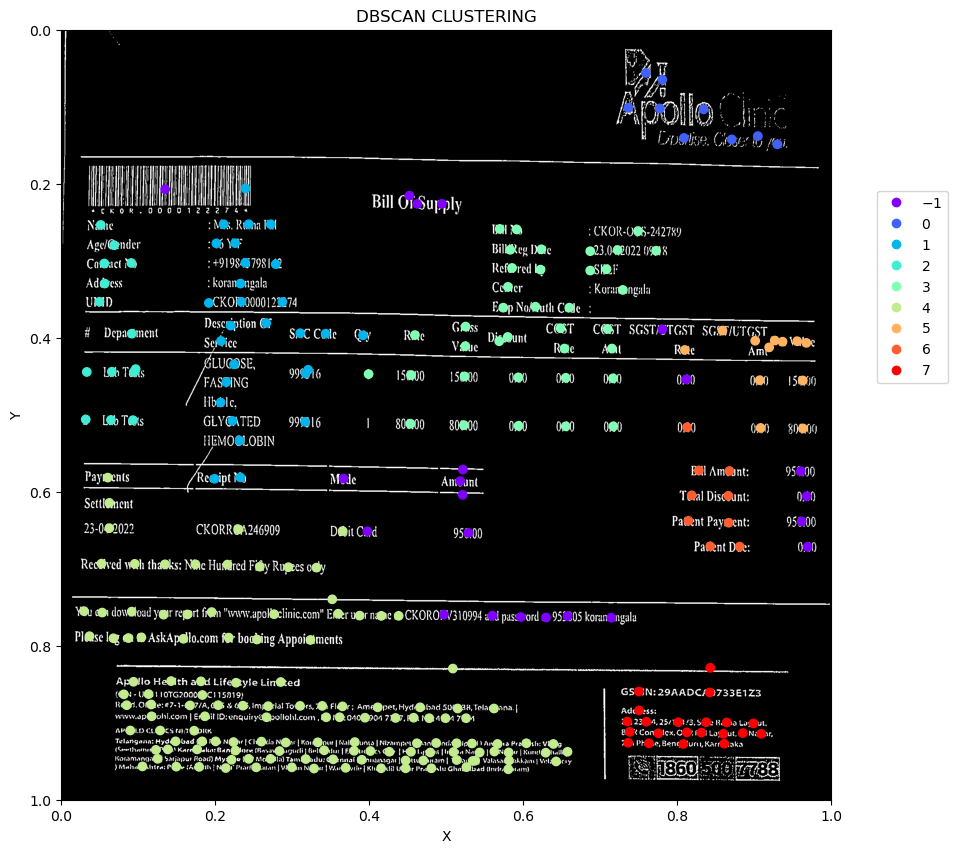

In [21]:
XTrain = data[["x", "y"]]

ms, eps, score = estimateParameter(imagePath)
clustering = DBSCAN(eps=eps, min_samples=ms).fit(XTrain)
data.loc[:, "Cluster"] = clustering.labels_

X = data["x"].to_numpy()
Y = data["y"].to_numpy()
clusters = data["Cluster"].to_numpy()

plt.figure(figsize=(12, 10))
plt.ylim(1, 0)
plt.xlim(0, 1)
plt.imshow(image, extent=[0, 1, 1, 0], cmap="gray")
scatter = plt.scatter(X, Y, c=clusters, cmap="rainbow")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("DBSCAN CLUSTERING")
plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.show()